# **Customer Retention**
 *A Data Science Project By Aparna Shasty*

## Overview

+ Recognizing/defining the business problem
+ Data Wrangling
+ Exploratory Data Analysis (EDA) and Visualizations
+ Data Storytelling
+ Training and Testing Machine Learning models
+ Recommendations to retain the customers
+ Scope for future work
+ A Final Note
+ References

### 1) Business Problem

A telecom company has been affected by the increasing number of customers subscribing to the services of a competitor. It is much more expensive to attract new customer than retaining old customer. At the same time, spending too much on or spending on the wrong factor for retaining customer who has no intention to leave (or who was not leaving for that factor which was addressed) could be a waste of  money. Therefore it is important to identify the customer who has high probability of leaving and zero down on the reason for it. An analysis of the past records of the customers can give great insights on who might leave and what is the cause. The telecom company already has this data available and data scientist need not collect the data in this case. The data can be found in [IBM page](https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/) : [Telecom Dataset]('https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv')

### Step by Step approach to Predicting and Preventing Customer Churn Rate
#### Quick Examination of the Dataset

In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pylab

import time
from scipy.stats import pearsonr

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
ch = pd.read_csv('https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv')
ch.info()
ch.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Note that,

Target (Dependent) Variable: **Churn**

Feature (Independent) Variables: 19 of them out of 21 shown above. Churn is target, Customer ID is just unique identity.

**We can divide predictor variables into,**
+ Service specific : 
  - Phone: PhoneService, MultipleLines
  - Internet: InternetService, Online Security, Online backup, Streaming TV, Streaming Movies, Tech support, Device protection
+ Person specific : gender, SeniorCitizen,Partner, Dependents, tenure (loyalty)
+ Money specific: Monthly Charges, TotalCharges, Contract, Paperlessbilling, Payment Method

In a real scenario, we would get additional information from the business owner on relationship between charges and remaining factors. Still we will have to verify them from the data, because their assumptions on how they run business and the reality can differ. Hence,

**The Questions to which we seek answers:**
- Are monthly charges different for different contract types?
- Are monthly charges solely dependent on the number/type of the services?
- Are there any discounts given to loyal customers?
- Is there a correlation between monthly charges and churn?
- Is there a correlation between tenure and churn?
- Is there a correlation between certain type of services and churn?
- Is there any person specific trends in churn?
- Can we make predictions on likelihood of a customer churn given the predictor variables listed above

and, Try quantifying these correlations into actionable items.

First check what percentage of the given dataset has data for customers who switch and what percentage is loyal?

Overall Customer Churn percentage in the given dataset is 26.54 %


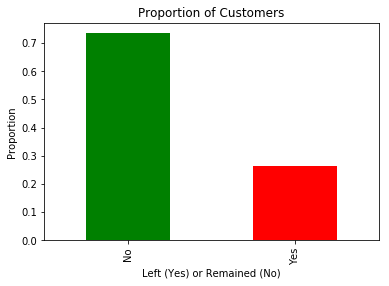

In [3]:
_ = (ch.groupby('Churn')['customerID'].count()/ch['customerID'].count()).plot.bar(color='gr')
_ = plt.title('Proportion of Customers')
_ = plt.ylabel('Proportion')
_ = plt.xlabel('Left (Yes) or Remained (No)')
print('Overall Customer Churn percentage in the given dataset is {} %'.format(round(ch.Churn.replace({'No':0,'Yes':1}).mean()*100,2)))

26.54% or 1869 of the 7043 records in the dataset belong to customers who switched to a competitor. This is a binary classification problem with moderately  imbalanced dataset. 

### 2) Data Wrangling
The output of the cell number 2 above gives all the data types and counts of non-null entries. Non-null does not mean valid entries. We need to ensure all of them have meaningful datatypes and valid entries. The TotalCharges is of type object, which means there is some non-numeric entry. It is expected to be float. Look at non-churn and churn group separately, as their dynamics might differ. Compute the I choose to impute the invalid entries with median of each group.

Senior Citizen is a category variable, however it is given as int. It need not be converted, as it will be eventually converted back to numeric.

In [4]:
# Examine the rows with total charges blank
ch[ch['TotalCharges'] == ' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


tenure for all these 11 rows is 0. Churn is "No". One can interpret this as belonging to all new customers, if indeed these are the only rows with tenure = 0 too. This is verified to be true below. Hence we can set TotalCharges to 0, whenever tenure is 0.

In [5]:
ch[ch['tenure'] == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [6]:
ch.TotalCharges = ch.TotalCharges.apply(lambda x: 0  if x == ' ' else float(x))

In [7]:
# Change No internet service to NoInt for brevity
ch[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']] = ch[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].astype(str).replace({'No internet service': 'NoInt'})
ch['MultipleLines'] = ch['MultipleLines'].replace({'No phone service':'NoPh'})

All other variables are fine. Converting object data types to categories and doing one hot encoding are explained along the way. 
### **3) Exploratory Data Analysis, Data Story Telling**

Now that we have clean data, let us quantify what impact this project could make, if all the customers who go away can be convinced to staying. We will also group tenure into 4 categories for better comprehension.

Total Revenue Lost/Month due to Churn: $ 139130


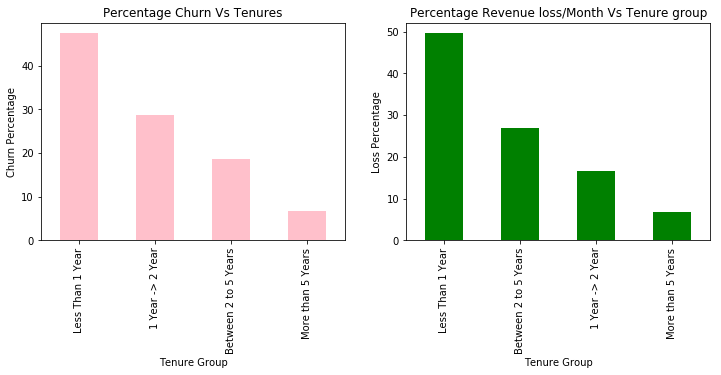

In [8]:
# Split the customers into 4 groups of tenures and see their Churn Rate
_ = plt.figure(figsize=(12,4))
_ = plt.subplot(1,2,1)
ch['Tenure Group'] = 'Between 2 to 5 Years'
ch.loc[ch['tenure'] >59,'Tenure Group'] = 'More than 5 Years' 
ch.loc[ch['tenure'] <= 24,'Tenure Group'] = '1 Year -> 2 Year'
ch.loc[ch['tenure'] <= 12,'Tenure Group'] = 'Less Than 1 Year'
ch['Ch10'] = ch['Churn'].replace({'Yes':1,'No':0})
ch_rate = ch.groupby('Tenure Group')['Ch10'].mean().sort_values(ascending=False)
(round(100*ch_rate,2)).plot.bar(color='pink')

# Evaluate the Revenue Loss per month
ch['revloss'] = ch['MonthlyCharges']*ch['Ch10']
_ = plt.ylabel('Churn Percentage')
_ = plt.title('Percentage Churn Vs Tenures')
_ = plt.subplot(1,2,2)
revenue_group = ch.groupby('Tenure Group')['revloss'].sum().sort_values(ascending=False)
(round(100*revenue_group/revenue_group.sum(),2)).plot.bar(color='g')
_ = plt.ylabel('Loss Percentage')
_ = plt.title('Percentage Revenue loss/Month Vs Tenure group')
print('Total Revenue Lost/Month due to Churn: $',int(revenue_group.sum()))

+ The business is losing approx $140k every month as per the current data!
+ Customers less than 1 year have the highest churn and cause highest loss.
+ The second and third place are interchanged in the two plots. 

A business would be interested in retaining the category that causes higher loss with immediate priority, as that will be more return on investment. 

In [9]:
# Check the stats for numeic types within Churn and No Churn group
numvar = ['tenure','MonthlyCharges','TotalCharges']
round(ch.groupby('Churn')[numvar].describe().T,2)

Churn                      No      Yes
tenure         count  5174.00  1869.00
               mean     37.57    17.98
               std      24.11    19.53
               min       0.00     1.00
               25%      15.00     2.00
               50%      38.00    10.00
               75%      61.00    29.00
               max      72.00    72.00
MonthlyCharges count  5174.00  1869.00
               mean     61.27    74.44
               std      31.09    24.67
               min      18.25    18.85
               25%      25.10    56.15
               50%      64.43    79.65
               75%      88.40    94.20
               max     118.75   118.35
TotalCharges   count  5174.00  1869.00
               mean   2549.91  1531.80
               std    2329.95  1890.82
               min       0.00    18.85
               25%     572.90   134.50
               50%    1679.52   703.55
               75%    4262.85  2331.30
               max    8672.45  8684.80

+ Mean tenure for Churn group is lower than the other group, which is as expected.
+ Mean Monthly charges are higher for Churn group, this has to be analyzed further.
+ Mean Total Charges is higher for loyal group than the churn group.

Mean Tenure of Two groups
 Churn
No     37.57
Yes    17.98
Name: tenure, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


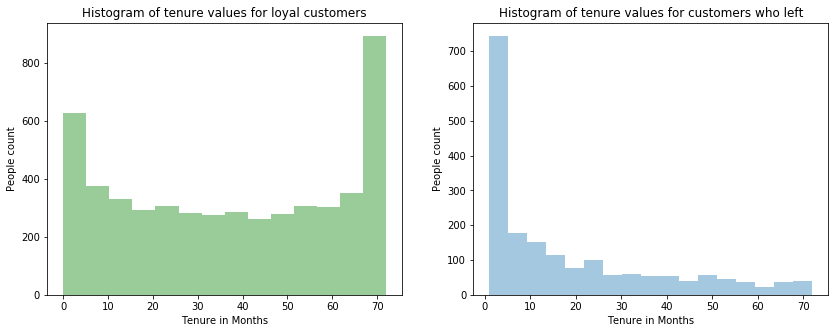

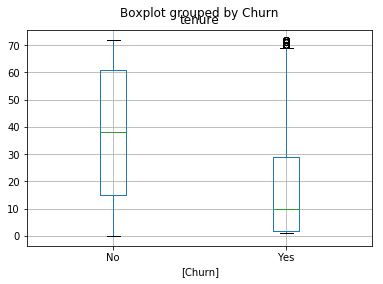

In [10]:
# Plot the histogram of the tenure and see if it tells any story!
fig, ax = plt.subplots(figsize=(14,5))
_ = plt.subplot(1,2,1)
sns.distplot(ch.loc[ch.Churn=='No','tenure'],hist=True,color='g',kde=False)
_ = plt.title('Histogram of tenure values for loyal customers')
_ = plt.xlabel('Tenure in Months')
_ = plt.ylabel('People count')
_ = plt.subplot(1,2,2)
sns.distplot(ch.loc[ch.Churn=='Yes','tenure'],hist=True,kde=False)
_ = plt.title('Histogram of tenure values for customers who left')
_ = plt.xlabel('Tenure in Months')
_ = plt.ylabel('People count')
print("Mean Tenure of Two groups\n",round(ch.groupby('Churn').tenure.mean(),2))
_ = plt.figure()
_ = ch[['Churn','tenure']].boxplot(by='Churn')

**Remarks: ** There is a clear distinction in the shape of the two histograms above. The percentiles are visible in the box plot. 
+ Customers who cut the contract are highly concentrated towards lesser tenure (<= 6 months). The number of customers in each higher bin progressively reduces.!
+ The first peak in the first plot tells that there are many more new customers than those in each of the other bins except the last one.
+ First bin to second bin, there is huge reduction, as some have Churned. There is slight reduction until bin centered at 40.
+ Customers who have crossed 20 months are likely to remain loyal and hence the counts are almost same until bin centered 60.
+ The last peak is a fact about the current dataset. It seems like there are many old customers (count > 850) who have stayed with the company's connection for more than 66 months. Suddenly there was a drop in number of customers and that is why there is less count in the bin previous to that. This clearly means, **Many customers switched to other companies about 5.5 years ago.** There could be a number of reasons for this:
   - This business entity might not have been able to upgrade its services to state of the art technology. 
   - There was monopoly but suddenly a competitor company popped up and attracted its customers with inauguration offers.
   - The progressive decrease from bin 65 to bin 60 to bin 55 and so on support the above points.
   - We can not do further analysis on this currently, as there is no data for customers who left 5.5 years ago. We only know the number of such customers.

In [11]:
# Find the correlation between tenure*Monthly Vs TotalCharges
print("Correlation between Monthly*tenure Vs. Total Charges:",pearsonr(ch.tenure*ch.MonthlyCharges,ch.TotalCharges))

Correlation between Monthly*tenure Vs. Total Charges: (0.99956055379722786, 0.0)


In [12]:
ch['Temp'] = ch.tenure*ch.MonthlyCharges
lm = ols('TotalCharges ~ Temp',ch).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           TotalCharges   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 8.006e+06
Date:                Wed, 14 Feb 2018   Prob (F-statistic):               0.00
Time:                        11:55:25   Log-Likelihood:                -39627.
No. Observations:                7043   AIC:                         7.926e+04
Df Residuals:                    7041   BIC:                         7.927e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9229      1.136     -0.812      0.417      -3.150       1.304
Temp           1.0005      0.000   2829.477      0.000       1.000       1.001
==============================================================================
Omnibus:                      538.795   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3067.278
Skew:                          -0.034   Prob(JB):                         0.00
Kurtosis:                       6.232   Cond. No.                     4.56e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

TotalCharges should be removed, as it is just monthly charges accumulated till date, as shown by the regression model above.

In [13]:
ch.drop(['Temp'],axis=1,inplace=True)

Mean Churn Across Contract
Month-to-month    0.427097
One year          0.112695
Two year          0.028319
Name: Ch10, dtype: float64
Mean Churn Across PhoneService
No     0.249267
Yes    0.267096
Name: Ch10, dtype: float64
Mean Churn Across InternetService
DSL            0.189591
Fiber optic    0.418928
No             0.074050
Name: Ch10, dtype: float64


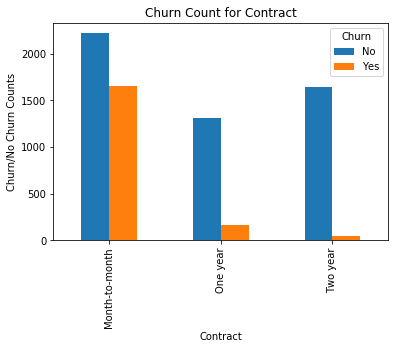

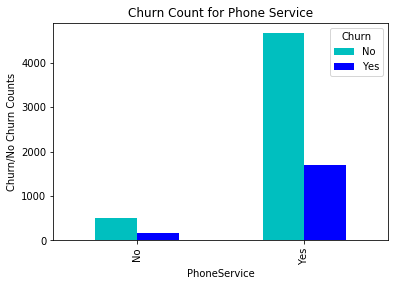

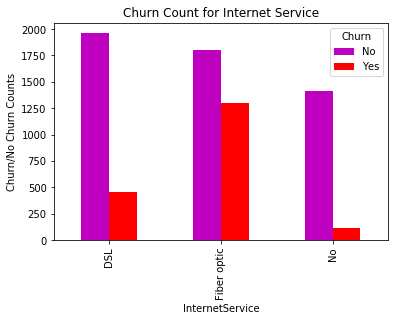

In [14]:
_ = pd.crosstab(ch.Contract,ch.Churn).plot.bar()
_ = plt.title('Churn Count for Contract')
_ = plt.ylabel('Churn/No Churn Counts')
print('Mean Churn Across',ch.groupby('Contract')['Ch10'].mean())
_ = pd.crosstab(ch.PhoneService,ch.Churn).plot.bar(color='cb')
_ = plt.title('Churn Count for Phone Service')
_ = plt.ylabel('Churn/No Churn Counts')
_ = pd.crosstab(ch.InternetService,ch.Churn).plot.bar(color='mr')
_ = plt.title('Churn Count for Internet Service')
_ = plt.ylabel('Churn/No Churn Counts')
print('Mean Churn Across',ch.groupby('PhoneService')['Ch10'].mean())
print('Mean Churn Across',ch.groupby('InternetService')['Ch10'].mean())

**Remark**: The Mean Rates printed above the plots only give some idea on the churn rate and that can give skewed perception on importance of set of people in a category.

The plots serve two purposes. They give counts and the relative counts of Churn Vs No churn. Across the categories, they tell us, which category has more members. This is helpful in deciding a few things. Let me explain with an example of Contract.

The month to month contract has high number of people in general and higher proportion of people Churning. The Contract with 2 years has the least members across categories and also within the category, relatively smaller proportion of the people Churn.

Similar Statements can be made about the other two plots. However, they do not give us an integrated picture of which combinations lead to certain customers' dissatisfaction. Hence we need a model to derive the relationship across them.

In [15]:
# Phone service is redundant.
print("Multiple Lines category counts:\n",ch.MultipleLines.value_counts())
print("Phone Lines category counts:\n",ch.PhoneService.value_counts())

Multiple Lines category counts:
 No      3390
Yes     2971
NoPh     682
Name: MultipleLines, dtype: int64
Phone Lines category counts:
 Yes    6361
No      682
Name: PhoneService, dtype: int64


**Remark:**From the above, Phone service is a subset of multiple lines. It does not contain any new information. Hence we choose to omit it. 

We can not rule out the possibility that the digits in customerID has some kind of information encoded. It can be taken up as future work. At this time, for ease of analysis, let us drop it.

In [16]:
y = ch.Ch10
X = ch.drop(['customerID','Churn','Ch10','TotalCharges','PhoneService','Tenure Group','revloss'],axis=1,inplace=False).copy()
temp = ch[['tenure','MonthlyCharges','SeniorCitizen']]
X.drop(['tenure','MonthlyCharges','SeniorCitizen'],axis=1,inplace=True)
X = X.apply(lambda x: x.astype('category')).apply(lambda x: x.cat.codes)
X[['tenure','MonthlyCharges','SeniorCitizen']] = temp

Percentage Variance by removing TotalCharges: [  6.54000000e+01   3.41100000e+01   8.00000000e-02   6.00000000e-02
   6.00000000e-02   4.00000000e-02   4.00000000e-02   4.00000000e-02
   3.00000000e-02   3.00000000e-02   3.00000000e-02   2.00000000e-02
   2.00000000e-02   2.00000000e-02   1.00000000e-02   1.00000000e-02
   1.00000000e-02]


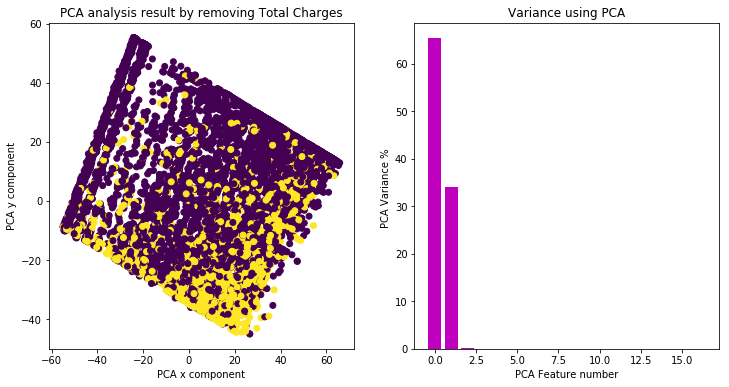

In [17]:
# We will reduce all features to 2D by PCA.
from sklearn.decomposition import PCA
fig = plt.figure(figsize=(12,6))
pca = PCA()
xx = pca.fit_transform(X)
xs = xx[:,0]
ys = xx[:,1]
fig.add_subplot(1,2,1)
_ = plt.scatter(xs,ys,c=y)
_ = plt.title('PCA analysis result by removing Total Charges')
_ = plt.xlabel("PCA x component")
_ = plt.ylabel("PCA y component")
fig.add_subplot(1,2,2)
_ = plt.bar(np.arange(pca.n_components_),100*np.round(pca.explained_variance_ratio_,4),color='m')
_ = plt.xlabel("PCA Feature number")
_ = plt.ylabel("PCA Variance % ")
_ = plt.title('Variance using PCA')
print("Percentage Variance by removing TotalCharges:",100*np.round(pca.explained_variance_ratio_,4))

**Remark**: The PCA indicates that there are two dominant components which explain all the variance! My guess would be tenure and MonthlyCharges.  

Percentage Variance by tenure and monthly charges: [  9.87190000e+01   1.89000000e-01   1.79100000e-01   1.55800000e-01
   1.15400000e-01   1.04800000e-01   9.04000000e-02   8.60000000e-02
   8.09000000e-02   7.23000000e-02   5.19000000e-02   4.33000000e-02
   4.08000000e-02   3.28000000e-02   2.26000000e-02   1.59000000e-02]


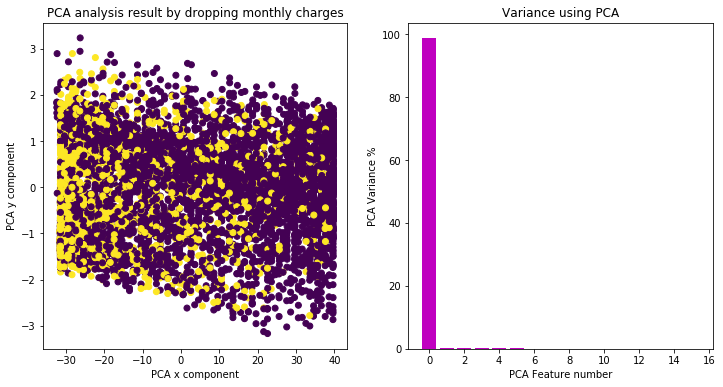

In [18]:
X1 = X.drop(['MonthlyCharges'],axis=1,inplace=False)
fig = plt.figure(figsize=(12,6))
xx = pca.fit_transform(X1)
xs = xx[:,0]
ys = xx[:,1]
fig.add_subplot(1,2,1)
_ = plt.scatter(xs,ys,c=y)
_ = plt.title('PCA analysis result by dropping monthly charges')
_ = plt.xlabel("PCA x component")
_ = plt.ylabel("PCA y component")
fig.add_subplot(1,2,2)
_ = plt.bar(np.arange(pca.n_components_),100*np.round(pca.explained_variance_ratio_,4),color='m')
_ = plt.xlabel("PCA Feature number")
_ = plt.ylabel("PCA Variance %")
_ = plt.title('Variance using PCA')
print("Percentage Variance by tenure and monthly charges:",100*np.round(pca.explained_variance_ratio_,6))

**Remarks: ** 
If we remove tenure and monthly charges, variance is spread across other features. But there is one of them much higher than all others.

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
gender              7043 non-null int8
Partner             7043 non-null int8
Dependents          7043 non-null int8
MultipleLines       7043 non-null int8
InternetService     7043 non-null int8
OnlineSecurity      7043 non-null int8
OnlineBackup        7043 non-null int8
DeviceProtection    7043 non-null int8
TechSupport         7043 non-null int8
StreamingTV         7043 non-null int8
StreamingMovies     7043 non-null int8
Contract            7043 non-null int8
PaperlessBilling    7043 non-null int8
PaymentMethod       7043 non-null int8
tenure              7043 non-null int64
MonthlyCharges      7043 non-null float64
SeniorCitizen       7043 non-null int64
dtypes: float64(1), int64(2), int8(14)
memory usage: 261.4 KB


### K-Means Clustering:

Clustering is done on tenure and Monthly Charges to get intuitive feel for the customer groups behavior. Churn population and non-Churn population are separately clustered into 3 and compared.

Cluster Centers for loyal customers are at:
Month, Dollars, Numbers
[ 47.46  93.87] 438
[  8.82  83.58] 949
[  9.14  38.77] 482
Cluster Centers for loyal customers are at:
Month  Dollars  Numbers
[ 32.55  24.76] 1790
[ 59.2   89.49] 1862
[ 17.01  69.66] 1522


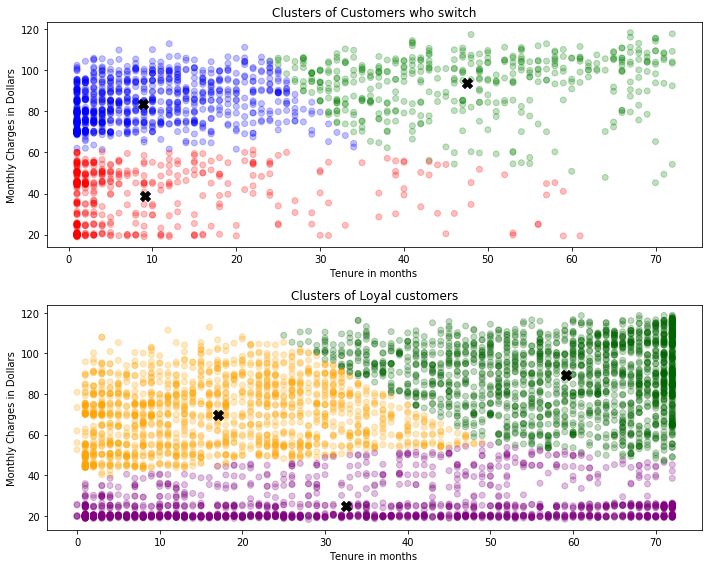

In [20]:
# Import KMeans Model
from sklearn.cluster import KMeans

# Graph and create 3 clusters of Customer Churn
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(ch[ch.Churn=='Yes'][["tenure","MonthlyCharges"]])

kmeans_colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in kmeans.labels_]
fig, ax = plt.subplots(figsize=(10, 8))
plt.subplot(2,1,1) #figsize=(10, 6))
plt.scatter(x="tenure",y="MonthlyCharges", data=ch[ch.Churn=='Yes'],
            alpha=0.25,color = kmeans_colors)
plt.xlabel("Tenure in months ")
plt.ylabel("Monthly Charges in Dollars")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Clusters of Customers who switch")
print("Cluster Centers for loyal customers are at:")
print("Month, Dollars, Numbers")
print(np.round(kmeans.cluster_centers_[0,:],2),(kmeans.labels_==0).sum())
print(np.round(kmeans.cluster_centers_[2,:],2),(kmeans.labels_==2).sum())
print(np.round(kmeans.cluster_centers_[1,:],2),(kmeans.labels_==1).sum())

plt.subplot(2,1,2)

# Graph and create 3 clusters of Customer Churn
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(ch[ch.Churn=='No'][["tenure","MonthlyCharges"]])

kmeans_colors = ['darkgreen' if c == 0 else 'orange' if c == 2 else 'purple' for c in kmeans.labels_]

plt.scatter(x="tenure",y="MonthlyCharges", data=ch[ch.Churn=='No'],
            alpha=0.25,color = kmeans_colors)
plt.xlabel("Tenure in months ")
plt.ylabel("Monthly Charges in Dollars")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Clusters of Loyal customers")
print("Cluster Centers for loyal customers are at:")
print("Month  Dollars  Numbers")
print(np.round(kmeans.cluster_centers_[1,:],2),(kmeans.labels_==1).sum())
print(np.round(kmeans.cluster_centers_[0,:],2),(kmeans.labels_==0).sum())
print(np.round(kmeans.cluster_centers_[2,:],2),(kmeans.labels_==2).sum())
_ = plt.tight_layout()

+ In the churn group (first plot), blue cluster has the maximum count. The number is more than sum of other two clusters. Indicates that relatively new customers but those who have subscribed to more services are the ones who are more likely to leave.

#### **Preparing the data for Predictive Analysis, by one-hot encoding**
Creating one hot encoding to suit Linear/Logistic regression is important for the correct interpretation of the features by the model. We do that below, and then drop original columns and the last column of each variable, as it is correlated to the others.

In [21]:
X = ch.drop(['customerID','Churn','Ch10','TotalCharges','PhoneService','Tenure Group','revloss'],axis=1,inplace=False).copy()
cat_vars=['gender','Partner','Dependents','PaperlessBilling','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaymentMethod']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(ch[var], prefix=var)
    X1=X.join(cat_list)
    X=X1
X.drop(cat_vars,axis=1,inplace=True) # Originals need to be dropped
X.drop(['MultipleLines_NoPh','InternetService_No','OnlineSecurity_No','OnlineBackup_No',
        'DeviceProtection_No','TechSupport_No','StreamingTV_No','StreamingMovies_No',        
        'gender_Male','Partner_No','Dependents_No','PaperlessBilling_No',
        'Contract_Month-to-month','PaymentMethod_Credit card (automatic)'],axis=1,inplace=True)
X.drop(['StreamingMovies_NoInt','StreamingTV_NoInt','TechSupport_NoInt','DeviceProtection_NoInt','OnlineBackup_NoInt','OnlineSecurity_NoInt'],axis=1,inplace=True)
XLin = X[[ 'MultipleLines_No', 'MultipleLines_Yes','InternetService_Fiber optic', 'InternetService_DSL',
         'OnlineSecurity_Yes','OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes','StreamingTV_Yes', 'StreamingMovies_Yes']]

In the Real Scenario, Data Scientist can ask questions to the business entity on how the customers are charged. Here we need to find out the relation between services and monthly Charges. We could try fitting a Linear Regression Curve. The customers are assumed to be independent. There are enough number of samples. We can plot the residuals later and check for normality. If it is found to be normal, with number of outliers(points beyond 2 stds) < 5% and if it explains 99% of the variance (R2 measure), we will accept it.

Our objective at this point is not prediction. It is to evaluate the coefficients of Linear regression, which tell us how much each service costs. This can later be used to quantify the gain in monthly revenue if some actions are taken which would result in retaining a customer.

Since it is not a predictive Linear Regression, but an inference one, we need not split it into Test and train set. There is no need to standardize any variable too.
When the first model was run, intercept came out to be < 10 cents. Hence ran this with intercept False

R^2 of the fit: 0.999
MSE of the model 1.05


,$ Per month
InternetService_Fiber optic,49.982
InternetService_DSL,25.004
MultipleLines_Yes,24.995
MultipleLines_No,19.978
StreamingTV_Yes,9.967
StreamingMovies_Yes,9.961
TechSupport_Yes,5.031
DeviceProtection_Yes,5.020
OnlineSecurity_Yes,5.016
OnlineBackup_Yes,4.991


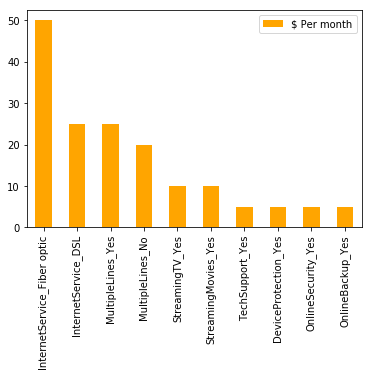

In [22]:
# Fit Linear Regression for Monthly Charges using services
from sklearn.linear_model import LinearRegression
LinReg = LinearRegression(fit_intercept=False)
yLin = ch.MonthlyCharges
LinReg.fit(XLin,yLin)
pred = LinReg.predict(XLin)
print("R^2 of the fit:",np.round(LinReg.score(XLin,yLin),3))
print("MSE of the model {:.2f}".format(np.mean((pred - yLin) ** 2)))
lincoeff = pd.DataFrame(np.round(LinReg.coef_,3),index=XLin.columns,columns=['$ Per month'])
lincoeff.sort_values('$ Per month',ascending=False).plot.bar(color='orange')
lincoeff.sort_values('$ Per month',ascending=False)

**Remarks:**
+ The Model is a Good fit as shown by R^2 and MSE
+ The monthly charges are proportional to services taken, no fixed charges.  
+ Fiber optic internet is the most expensive service at \$50, the double of DSL. 
+ Streaming Sevices are priced around \$9.94, Other internet related services are around \$
+ A single phone line costs \$20, an additional line costs \$5
+ We will next examine residuals just to make sure the assumptions hold true and hence results are reliable

Percentage of outliers:3.96


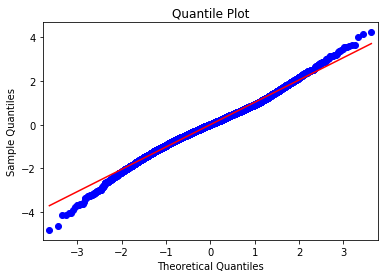

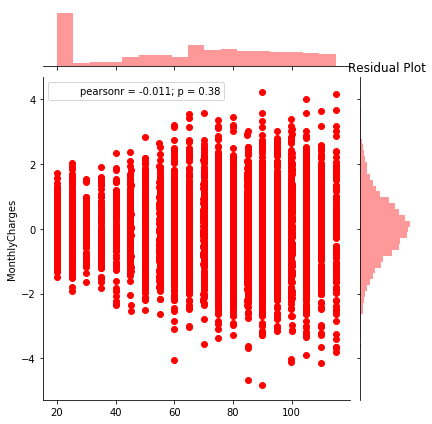

In [23]:
# Checking for verification of normality
resid = pred-yLin
_ = sm.qqplot(resid,line='r')
_ = plt.title('Quantile Plot')
_ = plt.figure()
_ = sns.jointplot(pred,resid,color='r')
_ = plt.title('Residual Plot')
print("Percentage of outliers:{:.2f}".format(100*((abs(resid) > 2.25).sum())*resid.std()/XLin.shape[0]))
#(abs(resid) > resid.std()unt()
#print("Indices of outlier points:",list(np.argsort(abs(pred-ydev)).tail(10)))

+ The quantile Plot is nearly linear implying normality.
+ Normal distribution is further confirmed by the histogram to the right of the second plot. (The residue Vs Monthly Charges)
+ Correlation of monthly charges with residual is very small. Indicates good fit
+ As a result, we include all other variables and drop MonthlyCharges from next predictive model

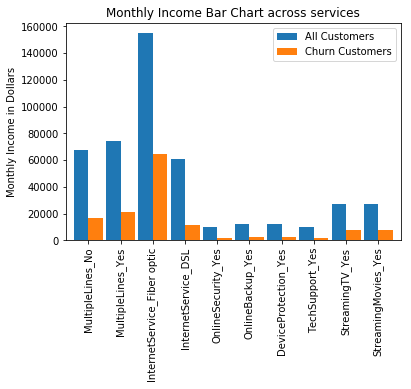

In [24]:
all_cust = round((np.sum(XLin,axis=0)*LinReg.coef_),2)
index1 = y > 0
churn_cust = round((np.sum(XLin.loc[index1,:],axis=0)*LinReg.coef_),2)
joined = pd.concat([all_cust,churn_cust],axis=1)
joined.columns = ['All Customers','Churn Customers']
joined.plot.bar(width = 0.9)
_ = plt.title('Monthly Income Bar Chart across services')
_ = plt.ylabel('Monthly Income in Dollars')


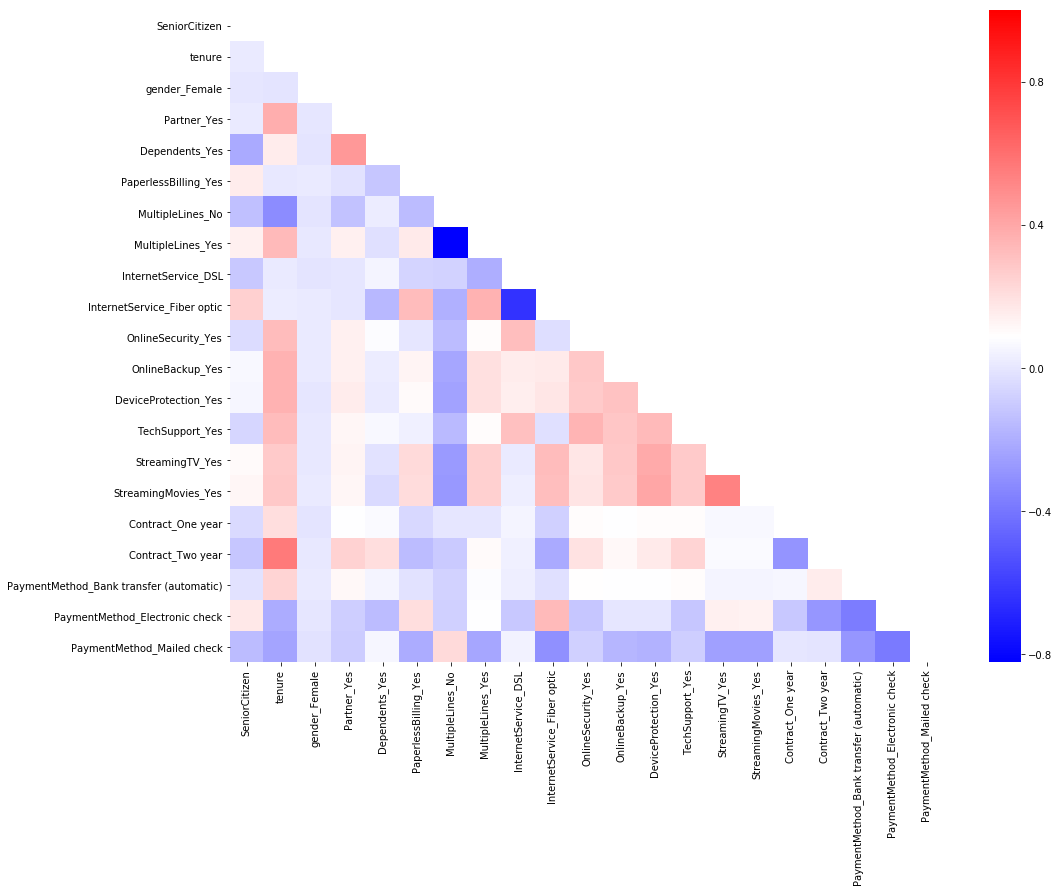

In [25]:
# We need to drop a few dummies to prevent correlations, in nonservice specific ones.
# Plotting correlation for top 10 features
# Ref : https://matplotlib.org/examples/color/colormaps_reference.html for colormap
X.drop('MonthlyCharges',axis=1,inplace=True)
_ = plt.figure(figsize=(16,12))
mask = np.zeros_like(X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(X.corr(),mask=mask,cmap='bwr')

Wow! That is good, except for a couple of strong squares. These will be okay.

### 4) Training and Testing Predictive Models
 
The goals of Predictive Model fitting are,
+ To identify the customers with high probability of switching to competition
+ To identify the major causes behind the tendency to leave (feature importance)
+ To make predictions and assess the capacity of the model for future data (Predictive power)
+ Use all the results and make recommendations to the telecom company.

#### Metrics to assess the model:
We are interested in customers who have tendency to go away (i.e. label 1). We may not mind a few false alarms especially if the measures taken to retain them is relatively inexpensive compared to the loss due to missing the true alarms. The measures taken on the customers who had no intention to leave can result in improved customer satisfaction and hence long term benefits.

We want high recall on class 1. 

In [26]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Logistc Regression Classifier

There are two numerical variables, and they don't need standardization. Result in terms of performance is found to be same with and without. Hence not doing.

Perc Cross Validation Scores with recall: [ 78.22  75.45  79.02  77.68  80.8 ]
Mean recall score : 78.23%
recall std : 1.75%
Perc Cross Validation Scores with accuracy: [ 74.7   76.09  73.85  74.67  76.54]
Mean accuracy score : 75.17%
accuracy std :  0.99%
Confusion Matrix:
      Pred N  Pred Y
No     1552     518
Yes     161     587
Report:
              precision    recall  f1-score   support

          0       0.91      0.75      0.82      2070
          1       0.53      0.78      0.63       748

avg / total       0.81      0.76      0.77      2818

Dev Set Accuracy:75.90 %
Train set Accuracy:75.48 %


Text(0.5,0,'False Positive Rate')

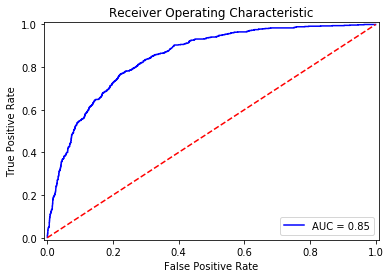

In [27]:
Xtrain, Xdev, ytrain,ydev = train_test_split(X,y,test_size=0.4,stratify=y)
# This is commented because hyperparameter tuning is not done currently.
#Xdev, Xtest, ydev,ytest = train_test_split(Xt,yt,test_size=0.5,random_state=42,stratify=yt)
logreg = LogisticRegression(C=100000,class_weight='balanced')
scores = 100*cross_val_score(logreg, Xtrain, ytrain, cv = 5, scoring='recall')
print('Perc Cross Validation Scores with recall:',np.round(scores,2))
print('Mean recall score : {:.2f}%'.format(np.mean(scores)))
print('recall std : {:.2f}%'.format(np.std(scores)))
scores = 100*cross_val_score(logreg, Xtrain, ytrain, cv = 5, scoring='accuracy')
print('Perc Cross Validation Scores with accuracy:',np.round(scores,2))
print('Mean accuracy score : {:.2f}%'.format(np.mean(scores)))
print('accuracy std :  {:.2f}%'.format(np.std(scores)))
logreg.fit(Xtrain,ytrain)
yp_dev = logreg.predict(Xdev)
lr=yp_dev
print("Confusion Matrix:\n",pd.DataFrame(confusion_matrix(ydev,yp_dev),columns=['Pred N','Pred Y'],index=['No','Yes']))
print("Report:\n",classification_report(ydev,yp_dev))
print("Dev Set Accuracy:{:.2f} %".format(100*accuracy_score(ydev,yp_dev)))
print("Train set Accuracy:{:.2f} %".format(100*accuracy_score(ytrain,logreg.predict(Xtrain))))
yprob = logreg.predict_proba(Xdev)
false_positive_rate, true_positive_rate, thresholds = roc_curve(ydev, yprob[:,1],pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

**Remarks:** The model is having similar accuracy on dev and train set. Since the class weight is set to balanced, the model has adjusted for imbalance by sampling methods. In logistic regression model, one can not do better than this, once the training and dev set accuracy is equal. Ref: The book, Introduction to Statistical Learning, Chapter 2

,Coeff value
InternetService_Fiber optic,1.759
Contract_Two year,-1.092
InternetService_DSL,0.787
Contract_One year,-0.672
PaymentMethod_Electronic check,0.418
MultipleLines_No,-0.403
TechSupport_Yes,-0.361
PaperlessBilling_Yes,0.355
OnlineSecurity_Yes,-0.338
StreamingMovies_Yes,0.333


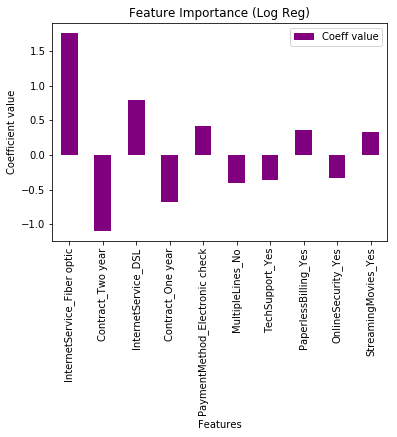

In [28]:
coeff=logreg.coef_
intercept = logreg.intercept_
coeffs_b= logreg.coef_[0,np.argsort(abs(logreg.coef_[0,:]))[::-1]]
names_b = list(X.columns[np.argsort(abs(logreg.coef_[0,:]))[::-1]])
logfimp = pd.DataFrame(np.round(coeffs_b,3),index=names_b,columns=['Coeff value'])
_ = logfimp.head(10).plot.bar(color='purple')
_ = plt.title('Feature Importance (Log Reg)')
_ = plt.ylabel('Coefficient value')
_ = plt.xlabel('Features')
logfimp

**Interpretation:** The negative coefficients indicate that customers with higher magnitude for negative coefficient tend to remain loyal and higher for positive coefficients indicate the opposite. 

**Scikit-learn's RFE**: Scikit Learn has a nice package called Recursive feature elimination (RFE). Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of RFE is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

Chosen Predictors: Index(['PaperlessBilling_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'TechSupport_Yes', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')
Report:
              precision    recall  f1-score   support

          0       0.91      0.68      0.78      2070
          1       0.48      0.81      0.60       748

avg / total       0.79      0.72      0.73      2818

Dev Set Accuracy % 71.58
Train set Accuracy % 72.28


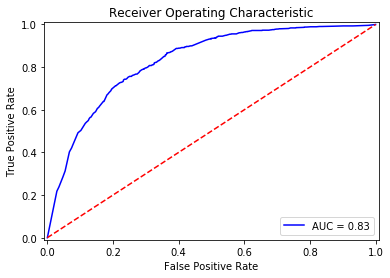

In [29]:
# Trying Feature Selection by limiting to 10
from sklearn.feature_selection import RFE
model = LogisticRegression(class_weight='balanced')
rfe = RFE(model, 10)
rfe = rfe.fit(Xtrain, ytrain)
# After RFE has chosen, now do a prediction using that
print("Chosen Predictors:",X.columns[rfe.support_])
Xp = X.loc[:,X.columns[rfe.support_]]
Xtrain1, Xt, ytrain1,yt = train_test_split(Xp,y,test_size=0.4,stratify=y)
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(Xtrain1,ytrain1)
yp = logreg.predict(Xt)
print("Report:\n",classification_report(yt,yp))
print("Dev Set Accuracy %",np.round(accuracy_score(yt,yp)*100,2))
print("Train set Accuracy %",np.round(accuracy_score(ytrain1,logreg.predict(Xtrain1))*100,2))
yprob = logreg.predict_proba(Xt)
false_positive_rate, true_positive_rate, thresholds = roc_curve(yt, yprob[:,1],pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
_ = plt.title('Receiver Operating Characteristic')
_ = plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
_ = plt.legend(loc='lower right')
_ = plt.plot([0,1],[0,1],'r--')
_ = plt.xlim([-0.01,1.01])
_ = plt.ylim([-0.01,1.01])
_ = plt.ylabel('True Positive Rate')
_ = plt.xlabel('False Positive Rate')

**Remarks**: Performance with RFE is slightly degraded. That is expected as only 10 predictors are used as opposed to double of that earlier.

In [30]:
# Coefficients with LogReg
coeffs = logreg.coef_[0,np.argsort(abs(logreg.coef_[0,:]))[::-1]]
names = list(Xp.columns[np.argsort(abs(logreg.coef_[0,:]))[::-1]])
print("Coefficients and their values in decreasing importance")
pd.DataFrame(np.round(coeffs,2),index=names,columns=['Coeff value'])

Coefficients and their values in decreasing importance


,Coeff value
Contract_Two year,-2.38
InternetService_Fiber optic,1.95
InternetService_DSL,1.22
Contract_One year,-1.11
PaymentMethod_Electronic check,0.53
OnlineSecurity_Yes,-0.47
OnlineBackup_Yes,-0.42
TechSupport_Yes,-0.40
PaymentMethod_Mailed check,0.38
PaperlessBilling_Yes,0.37


**Remarks**: The feature importance is not really matching with and without RFE. RFE is an overkill for problems with small number of features.

Threshold Chosen for classification: 0.5
Threshold Tenure:27 months
Max and Min Prob values:0.84 and 0.16
Train Set Accuracy :63.67%
Dev Set Accuracy 64.16%
Report:
              precision    recall  f1-score   support

          0       0.87      0.60      0.71      2070
          1       0.40      0.74      0.52       748

avg / total       0.74      0.64      0.66      2818

Coefficient:-0.037, Intercept:0.997


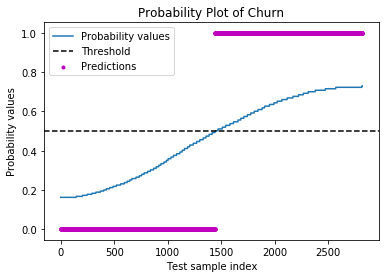

In [31]:
# To evaluate the extent of relation between churn and tenure, trying Logistic with tenure alone.
# Recognizing that tenure and churn are just correlated, it may not be causation
# We could verify if the coefficient with this is close to that obtained by the first 
# logistic regression that includes all variables
logreg_red = LogisticRegression(class_weight='balanced')
Xtrain, Xdev, ytrain,ydev = train_test_split(np.array(ch['tenure']),y,test_size=0.4,random_state=42,stratify=y)
logreg_red.fit(Xtrain.reshape(-1,1),ytrain)
ypred_red = logreg_red.predict_proba(Xdev.reshape(-1,1))
_ = plt.plot(np.sort(ypred_red[:,1]),label = 'Probability values')
ypred = logreg_red.predict(Xdev.reshape(-1,1))
ypred_s = ypred[np.argsort(ypred_red[:,1])]
spred = np.sort(ypred_red[:,1])
vline = spred[ypred_s.argmax()]
print("Threshold Chosen for classification:",round(vline,2))
print("Threshold Tenure:{} months".format(round(0.997/0.037)))
print("Max and Min Prob values:{} and {}".format(round(ypred_red.max(),2),round(ypred_red.min(),2)))
_ = plt.axhline(vline,color='k',linestyle='--',label = 'Threshold')
_ = plt.scatter(np.arange(len(ypred)),ypred_s,color='m',marker='.',label = 'Predictions')
_ = plt.legend(loc='best')
_ = plt.xlabel('Test sample index')
_ = plt.ylabel('Probability values')
_ = plt.title('Probability Plot of Churn')
print("Train Set Accuracy :{:.2f}%".format(100*accuracy_score(ytrain,logreg_red.predict(Xtrain.reshape(-1,1)))))
print("Dev Set Accuracy {:.2f}%".format(100*accuracy_score(ydev,ypred)))
print("Report:\n",classification_report(ydev,ypred))
print("Coefficient:{}, Intercept:{}".format(round(logreg_red.coef_[0,0],3),round(logreg_red.intercept_[0],3)))

Even with tenure alone it gives about 64% overall accuracy, a mere 11% reduction compared to all features taken for the fitting.
+ The coefficient value -0.037 is close to -0.030 obtained with the regression with all other variables included. This gives additional confidence.
+ Churn is closely negatively correled with tenure.
+ The curve ranges between 0.16 to 0.84, not between 0 to 1
+ The threshold of 0.5 corresponds to tenure = 27 months => contract of two year is preferred.
+ It should be noted that the sigmoid curve is almost linear between 0.66 and 0.23, corresponding to tenures 9 months and 60 months respectively. 
+ Before 9 months the curve is flat, implying, it takes lot of effort to make them subscribed for longer than a few months.
+ After 60 months it is again flat at the other end, implying these customers have stabilized


#### Data Preparation
The remaining part does not need one hot encoding, and also categories need to be handled again.

In [32]:
X_rf = X = ch.drop(['customerID','Churn','Ch10','TotalCharges','PhoneService','Tenure Group','revloss'],axis=1,inplace=False).copy()
temp = X_rf[['tenure','MonthlyCharges','SeniorCitizen']]
X_rf = X_rf.drop(['tenure','MonthlyCharges','SeniorCitizen'],axis=1)
X_rf = X_rf.apply(lambda x: x.astype('category')).apply(lambda x: x.cat.codes)
X_rf[['tenure','MonthlyCharges','SeniorCitizen']] = temp
Xtrain, Xdev, ytrain,ydev = train_test_split(X_rf,y,test_size=0.4,stratify=y)

### Random Forest Classifier
There is actually no need to drop correlated features for Random Forest. It selects best features at every node of every tree by itself. But from a business perspective, TotalCharges is related to monthly and tenure, we intentionally drop it to get the correct picture (better interpretation) on feature importance. Phone service is also dropped.

Confusion Matrix:
      Pred N  Pred Y
No     1480     590
Yes     146     602
Report:
              precision    recall  f1-score   support

          0       0.91      0.71      0.80      2070
          1       0.51      0.80      0.62       748

avg / total       0.80      0.74      0.75      2818

Dev Set Accuracy:73.88%
Train set Accuracy:74.89%


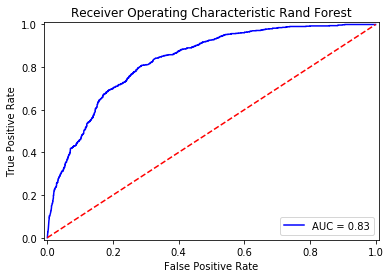

In [33]:
## Try fitting the Random forest.
rand_forest = RandomForestClassifier(25,'entropy',4,min_weight_fraction_leaf=0.03,class_weight='balanced',oob_score=True)
rand_forest.fit(Xtrain,ytrain)
yp_dev = rand_forest.predict(Xdev)
rf = yp_dev
print("Confusion Matrix:\n",pd.DataFrame(confusion_matrix(ydev,yp_dev),columns=['Pred N','Pred Y'],index=['No','Yes']))
print("Report:\n",classification_report(ydev,yp_dev))
print("Dev Set Accuracy:{:.2f}%".format(100*accuracy_score(ydev,yp_dev)))
print("Train set Accuracy:{:.2f}%".format(100*accuracy_score(ytrain,rand_forest.predict(Xtrain))))
yprob = rand_forest.predict_proba(Xdev)
false_positive_rate, true_positive_rate, thresholds = roc_curve(ydev, yprob[:,1],pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
_ = plt.title('Receiver Operating Characteristic Rand Forest')
_ = plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
_ = plt.legend(loc='lower right')
_ = plt.plot([0,1],[0,1],'r--')
_ = plt.xlim([-0.01,1.01])
_ = plt.ylim([-0.01,1.01])
_ = plt.ylabel('True Positive Rate')
_ = plt.xlabel('False Positive Rate')

,% feature importance
Contract,35.16
TechSupport,14.36
OnlineSecurity,14.12
tenure,14.10
MonthlyCharges,7.90
InternetService,5.07
OnlineBackup,3.18
PaymentMethod,1.80
StreamingMovies,1.12
PaperlessBilling,0.99


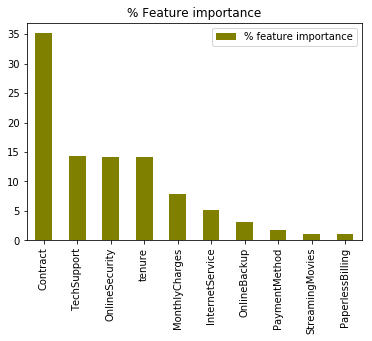

In [34]:
feature_labels = np.array(list(X_rf.columns))
importance = rand_forest.feature_importances_
feature_indexes_by_importance = importance.argsort()[::-1]
fimp = pd.DataFrame(np.round(importance[feature_indexes_by_importance] *100.0,2),index = feature_labels[feature_indexes_by_importance],columns=['% feature importance'])
_ = fimp.head(10).plot.bar(color='olive')
_ = plt.title('% Feature importance')
fimp.head(10)

### 5) Comparing The Results, Feature Importance: 
We found that Logistic Regression gives around 2% more accuracy and 1% more AUC than RandomForest Classifier. Also, it has better interpretability. For this problem, Logistic Regression is a better model that can be used to predict the customer tendency to churn and what actions from the business can make how much impact.

Decision Trees were also tried and kept below for records

Test accuracy:74.63%
Train accuracy:76.80%
Confusion Matrix:
 [[1539  531]
 [ 184  564]]
Report:
              precision    recall  f1-score   support

          0       0.89      0.74      0.81      2070
          1       0.52      0.75      0.61       748

avg / total       0.79      0.75      0.76      2818



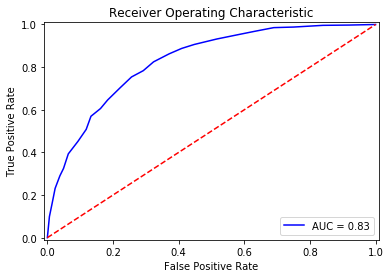

In [35]:
from os import system
dt = DecisionTreeClassifier(min_weight_fraction_leaf=0.03,class_weight='balanced')
dt.fit(Xtrain,ytrain)
dotfile = open("./dtree2.dot", 'w')
tree.export_graphviz(dt, out_file = dotfile, feature_names = Xtrain.columns)
dotfile.close()
system("cd C:/Users/Aparn/DataScience/Projects/mini_projects/customer_retention")
system("dot -Tpng dtree2.dot -o dtree2.png")
yp_dev = dt.predict(Xdev)
dtd=yp_dev
print("Test accuracy:{:.2f}%".format(100*accuracy_score(ydev,yp_dev)))
print("Train accuracy:{:.2f}%".format(100*accuracy_score(ytrain,dt.predict(Xtrain))))
print("Confusion Matrix:\n",confusion_matrix(ydev,yp_dev))
print("Report:\n",classification_report(ydev,yp_dev))
yprob = dt.predict_proba(Xdev)
false_positive_rate, true_positive_rate, thresholds = roc_curve(ydev, yprob[:,1],pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
_ = plt.title('Receiver Operating Characteristic')
_ = plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
_ = plt.legend(loc='lower right')
_ = plt.plot([0,1],[0,1],'r--')
_ = plt.xlim([-0.01,1.01])
_ = plt.ylim([-0.01,1.01])
_ = plt.ylabel('True Positive Rate')
_ = plt.xlabel('False Positive Rate')

 Decision tree is not bad at all with an AUC of 0.83! Accuracy is close to the other two. Really we didnt need RF!

In [36]:
# Predictive Model to use
# Assumes clean csv file
def cust_churn_prob_finder(coeff,intercept,csvfile):
    df = pd.read_csv(csvfile,usecols=range(20))
    df_monthly = df.MonthlyCharges
    df.drop(['TotalCharges','customerID','PhoneService','MonthlyCharges'],axis=1,inplace=True)
    cat_vars=['gender','Partner','Dependents','PaperlessBilling','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaymentMethod']
    for var in cat_vars:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(ch[var], prefix=var)
        X1=df.join(cat_list)
        df=X1
    df.drop(cat_vars,axis=1,inplace=True) # Originals need to be dropped
    df.drop(['MultipleLines_NoPh','InternetService_No','OnlineSecurity_No','OnlineBackup_No',
        'DeviceProtection_No','TechSupport_No','StreamingTV_No','StreamingMovies_No',        
        'gender_Male','Partner_No','Dependents_No','PaperlessBilling_No',
        'Contract_Month-to-month','PaymentMethod_Credit card (automatic)'],axis=1,inplace=True)
    df.drop(['StreamingMovies_NoInt','StreamingTV_NoInt','TechSupport_NoInt','DeviceProtection_NoInt','OnlineBackup_NoInt','OnlineSecurity_NoInt'],axis=1,inplace=True)
    prob_test = 1/ (1+ np.exp(-np.dot(np.array(df),coeff[0,:])-intercept))
    df['churn_prob'] = prob_test 
    df['charge*prob'] = df_monthly* prob_test 
    return df

In [37]:

df = cust_churn_prob_finder(coeff,intercept,'Churn.csv')
# numbers as found by Log Reg analysis

print("Report",classification_report(y,(df['churn_prob'] >= 0.5)))
print("Confusions\n",confusion_matrix(y,(df['churn_prob'] >= 0.5)))


Report              precision    recall  f1-score   support

          0       0.91      0.74      0.82      5174
          1       0.53      0.79      0.63      1869

avg / total       0.81      0.76      0.77      7043

Confusions
 [[3853 1321]
 [ 394 1475]]


In [38]:
df_churn = df[df['churn_prob'] >= 0.5]
index1 = df_churn.sort_values('charge*prob',ascending=False).index
temp = y*(df['churn_prob'] >= 0.5)
index2 = ch.loc[(temp > 0),'MonthlyCharges'].index
print("Potential revenue savings:${}".format(round(ch.loc[index2,'MonthlyCharges'].head(1485).sum())))

Potential revenue savings:$114687


### 6) Recommendations to retain the customers:
A predictive model is given that ranks customers based on their probability of churn and the revenue that they bring.
+ Use this model to prioritize whose concerns to be addressed first. Sometimes it might be case by case basis.
+ Take the following actions immediately: 
  - Try striking a longer contract with new customers: two year or one year in that order of preference.
  - Leverage the time to improve the quality of services, on the high cost ones like Fiber optic.
  - Improve on the Technical support on all services like streaming, phone connection and internet. 
Be up-to-date with current technology.
  - Collect customer feedback and act on it immediately to prevent new customer churn
+ Next: It will be helpful to understand why churn started 5.5 years ago. Give more historical data to the data scientist for analysis.


### 7) Scope for future work:
+ More predictive models could be tried, however, there is no guarantee of better accuracy, as we have seen similar accuracy witn logistic regression and random forest. This actually means most of the variance in the data is explained.
+ One could collect more data through surveys, analyze them using NLP techniques and take more measures.
+ There is a scope to collect historical data on company customers over a few decades, and fight out clear reason for customer drop happened 70 years ago.

### 8) A Final Note:

It was fun doing this small project. Made me understand what more I need to work on. In the process I learnt,
+ Data Science Process
+ To Apply Machine Learning basics studied in courses and text books. 
+ Metrics to measure the goodness of the model. Learnt that accuracy is definitely not a good enough measure in case of imbalanced classes. class_weight argument works magically!

Thanks for taking time to go through this project. Feedback is highly appreciated. Please email [me](mailto:aparnack@gmail.com) to discuss your views

### 9) References:

+ Introduction to Statistical Learning Book by Gareth James et. al
+ Machine Learning Course by Andrew Ng in Coursera
+ How to plot ROC is [here](https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/)
+ Colormap codes for heatmap [here](https://matplotlib.org/examples/color/colormaps_reference.html for colormap)
+ [Here](https://towardsdatascience.com/predict-customer-churn-with-r-9e62357d47b4) is another implementation of this problem by Susan Li in Towards Data Science blog